In [1]:
import numpy as np
import random
import os

from scipy import signal
from matplotlib import pyplot as plt

import pandas as pd
from tqdm.notebook import tqdm
%matplotlib inline
import matplotlib.pyplot as plt



from utils.augment import augment
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from utils.deep import preProcess, smoothLabels, oneHot, applyOneHot, evaluate_set
from utils.visualize import showMe, showHistory
#from utils.record import preProcess
from config.default import *

%load_ext autoreload
%autoreload 2


C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
classes = settings['classes']
clip_value = 2000
input_length = 100
root_path = 'C:/resources/EMG/'

post_fix = '_3s'
include = ['S004']
train_sessions = []
for subject in os.listdir(root_path):
    if subject in include:
        for session in os.listdir(os.path.join(root_path,subject)):
            train_sessions.append(os.path.join(root_path,subject, session))
        #print(f"{len(os.listdir(os.path.join(root_path,subject)))} session loaded from subject: {subject}")
print(f"{len(train_sessions)} sessions loaded for training")


#ACTUALLY LOAD TRAIN DATA
records = {}
for c in classes:
    class_data = []
    for session in train_sessions:
        class_data.append(np.load(os.path.join(session,c+post_fix+'.npy'),allow_pickle=True))
    records[c] = np.concatenate(class_data)

    #records[c]  = np.array([preProcess(s,clip_value,300) for s in records[c] ])


2 sessions loaded for training


In [26]:
input_length = 500
def showMeWorking(data, r=[-1,1]):
    plt.rcParams["figure.figsize"] = [10, 20]

    fig, ax = plt.subplots(facecolor ='#A0A0A0')

    i = 0

    for i in range(40):
        plt.subplot(8, 5, i+1)
        max = np.max(data[i])
        min = np.min(data[i])
        plt.title(max-min<4000)

        # maxs = []
        # for c in data[i]:
        #     maxs.append(np.argmax(np.gradient(np.gradient(c))))
        #     #maxs.append(np.argmax(np.gradient(np.gradient(c))))

        # #magic = np.array(maxs).mean()
        # magic = np.max(np.array(maxs))
        #############################################################
        gradient = np.gradient(data[i][-1])
        gradient = signal.resample(gradient,100)


        # Prefer early peaks
        adjust = np.linspace(0,0.01,100)
        gradient = gradient-adjust

        # Dont watch sides
        gradient[:10] = 0
        gradient[-10:] = 0
        
        magic = (np.argmax(gradient)*10)+5

        start = magic - 100
        end = magic + 400

        if start < 0:
            start = 0
            end = input_length
        if end > 1000:
            end = 1000
            start = 1000 - input_length


        plt.axvline(x=magic)

        for d in data[i]:
            #d = d[start:end]
            plt.plot(d)
            
            plt.ylim(r[0], r[1])
    plt.show()

In [64]:
input_length = 500
def showMeGradient(data, r=[-1,1]):
    plt.rcParams["figure.figsize"] = [10, 20]

    fig, ax = plt.subplots(facecolor ='#A0A0A0')

    i = 0

    for i in range(40):
        plt.subplot(8, 5, i+1)
    


        #plt.axvline(x=magic)

        for d in data[i]:
            plt.ylim(r[0], r[1])

            
            a = np.gradient(d)
            
            stdm = [0]
            for j in range(1,len(d)):
                stdm.append(np.std(d[:j])/j)
            stdm = np.array(stdm)
            stdm*=10

            gstdm = [0]
            for j in range(1,1000):
                gstdm.append(np.std(a[:j]))
            gstdm = np.array(stdm)
            gstdm*=10

            plt.plot(d)
            #plt.plot(np.gradient(stdm)*100)
            plt.plot(stdm*10)


            
            break
    plt.show()

In [31]:
a = [0,1,2]
print(a[:1])

[0]


In [20]:
input_length = 500
def showMe(data, r=[-1,1]):
    plt.rcParams["figure.figsize"] = [10, 20]

    fig, ax = plt.subplots(facecolor ='#A0A0A0')

    i = 0

    for i in range(40):
        plt.subplot(8, 5, i+1)
        #cutted = cut_out(data[i])

        for d in data[i]:
            #d = d[start:end]
            plt.plot(d)
            plt.ylim(r[0], r[1])
    plt.show()

In [41]:
input_length = 500
def showMeCutted(data, r=[-1,1]):
    plt.rcParams["figure.figsize"] = [10, 20]

    fig, ax = plt.subplots(facecolor ='#A0A0A0')

    i = 0

    for i in range(40):
        plt.subplot(8, 5, i+1)
        cutted = cut_out(data[i],percentage_before_magic = 0.4 )

        for d in cutted:
            #d = d[start:end]
            plt.plot(d)
            plt.ylim(r[0], r[1])
    plt.show()

In [37]:
def cut_out(data,
    input_length = 500,
    resample_rate = 10,
    early_focus_ratio = 0.01,
    percentage_before_magic = 0.2 
):
    

    resample_to = int(data.shape[-1]/resample_rate)
    border = int(resample_to/10)
    maxs = []
    for c in data:
        gradient = np.gradient(c)
        gradient = signal.resample(gradient,resample_to)

        # Prefer early peaks
        adjust = np.linspace(0,early_focus_ratio,resample_to)
        gradient = gradient-adjust

        # Dont watch sides
        gradient[:border] = 0
        gradient[-border:] = 0

        magic = (np.argmax(gradient)*resample_rate)+resample_rate/2
        maxs.append(magic)
    magic = np.array(maxs).mean()
   
    
    start = magic - input_length*percentage_before_magic
    end = magic + input_length*(1-percentage_before_magic)

    if start < 0:
        start = 0
        end = input_length
    if end > data.shape[-1]:
        end = data.shape[-1]
        start = data.shape[-1] - input_length


    return data[:,int(start):int(end)]


In [171]:
for r in records:
    print(r)
    print(records[r].shape)

Rest
(40, 4, 1000)
Chew
(40, 4, 1000)
Eyebrow
(40, 4, 1000)


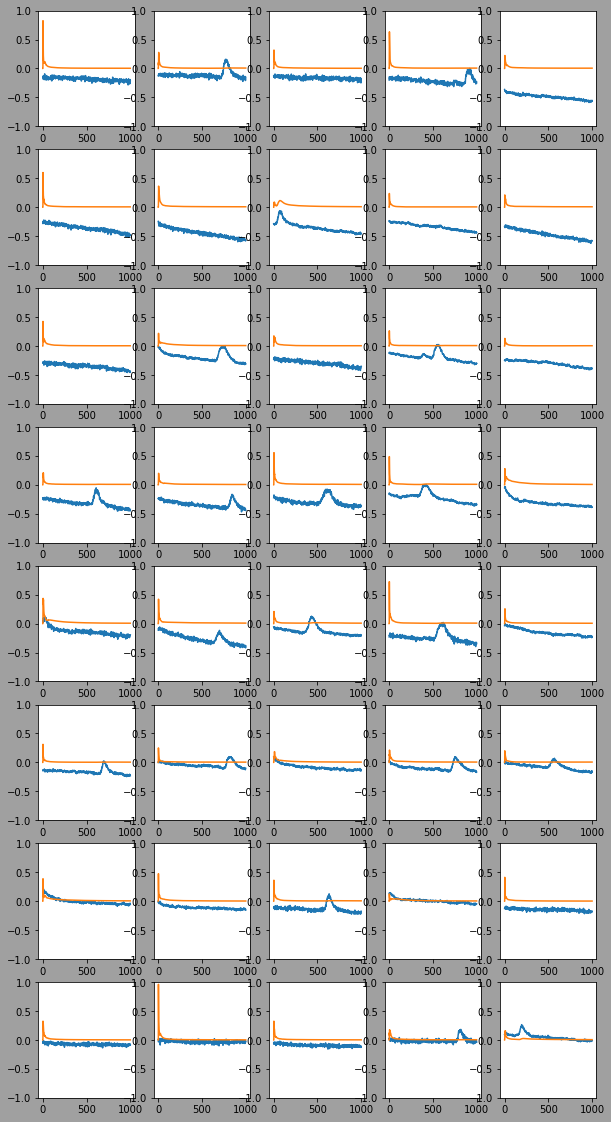

In [65]:
#np.random.shuffle(records['Rest'])
showMeGradient(records['Rest'])

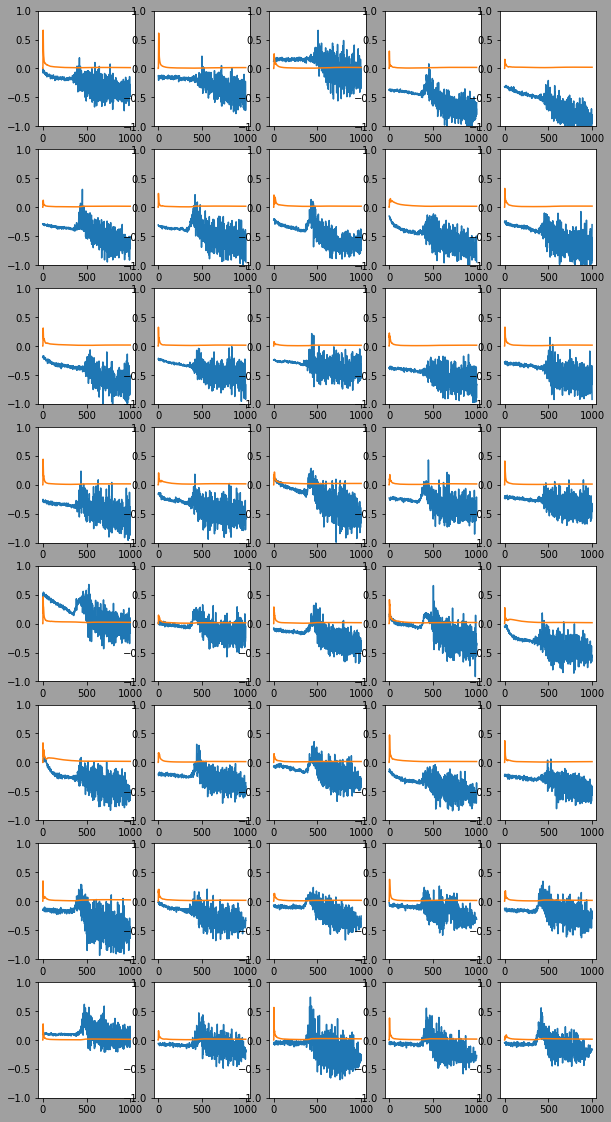

In [66]:
showMeGradient(records['Chew'])

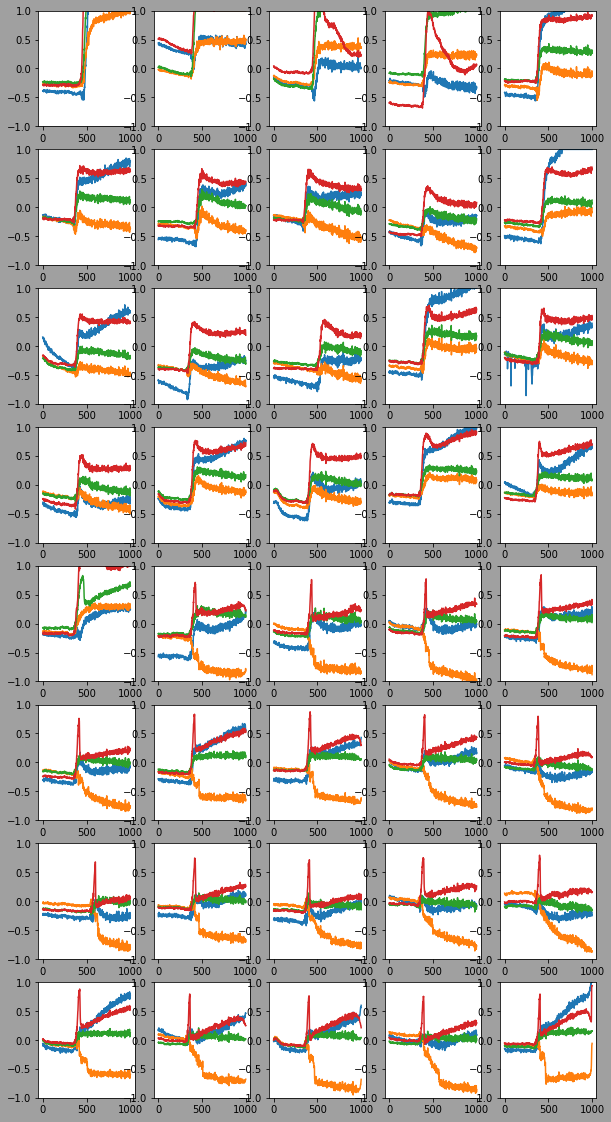

In [68]:
showMe(records['Eyebrow'])

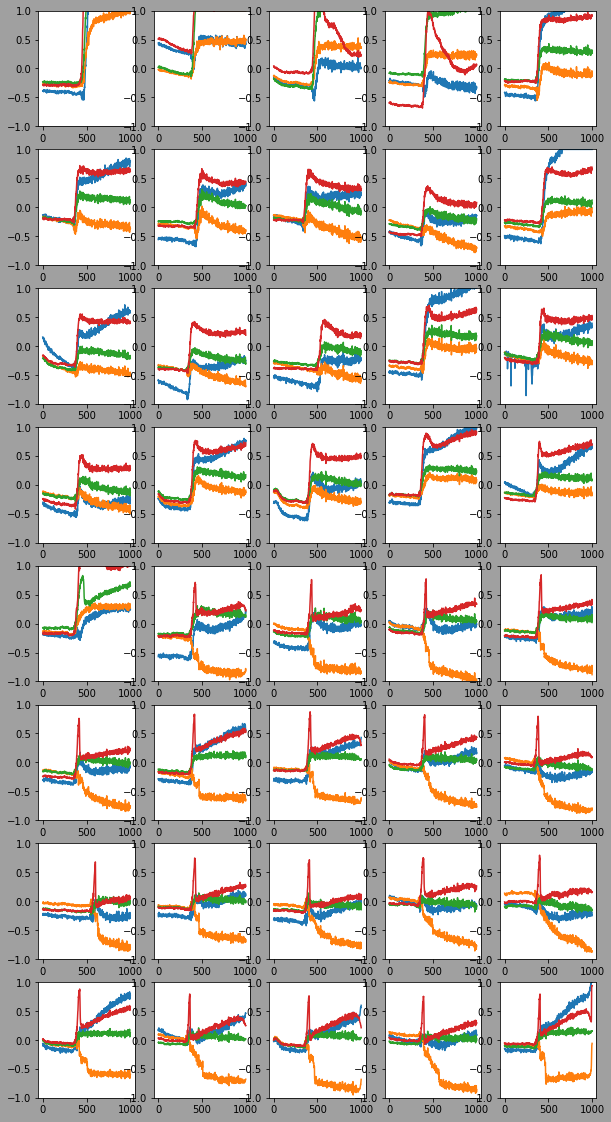

In [21]:
showMe(records['Eyebrow'])

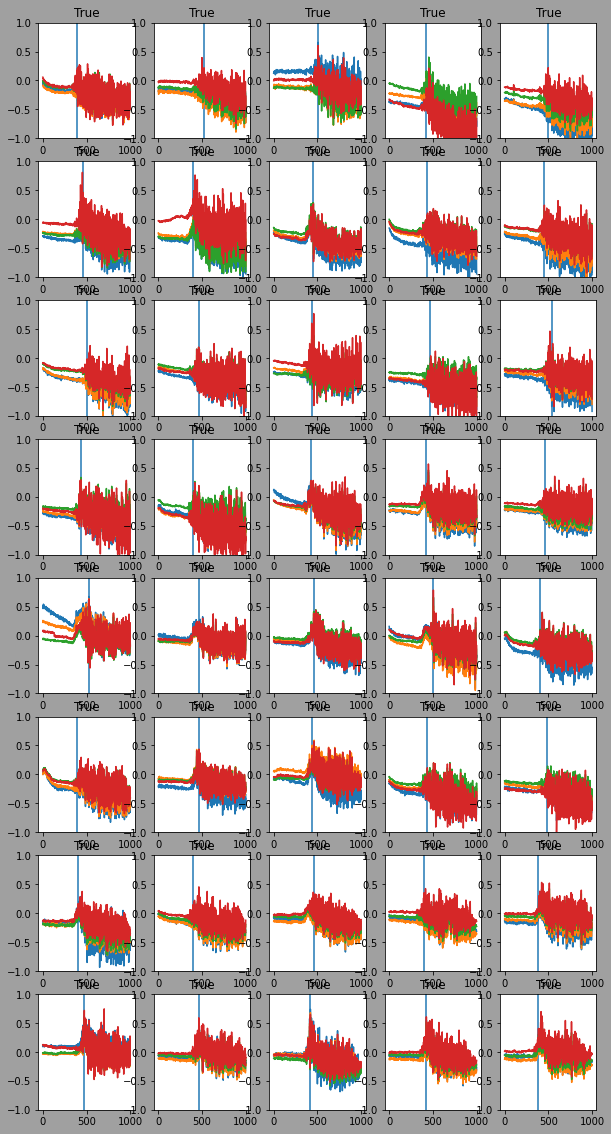

In [27]:
showMeWorking(data=records['Chew'])

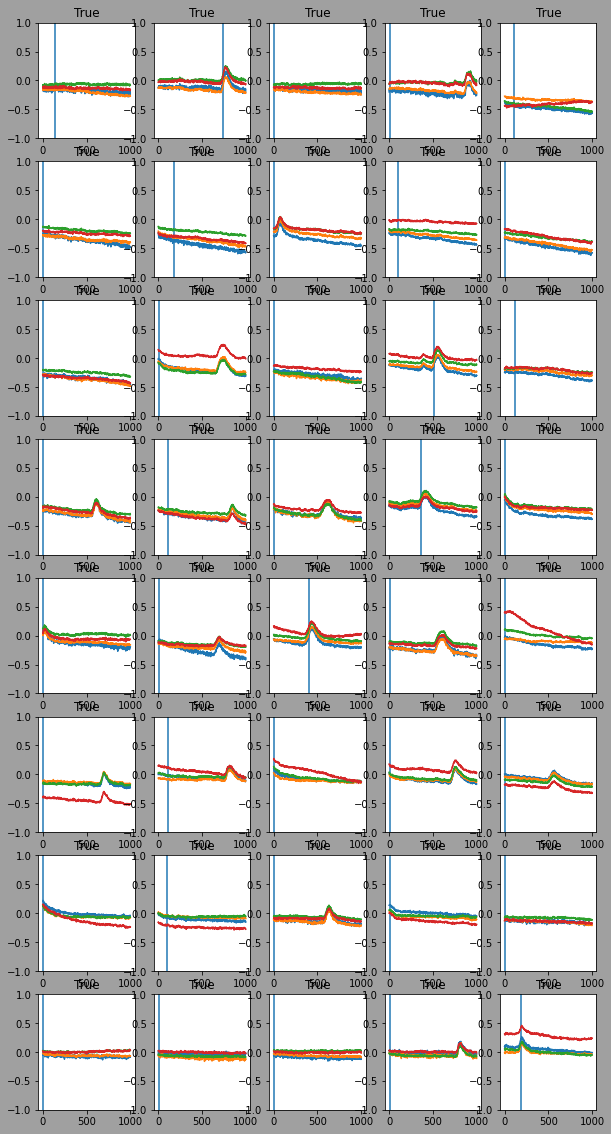

In [32]:
showMeWorking(data=records['Rest'])

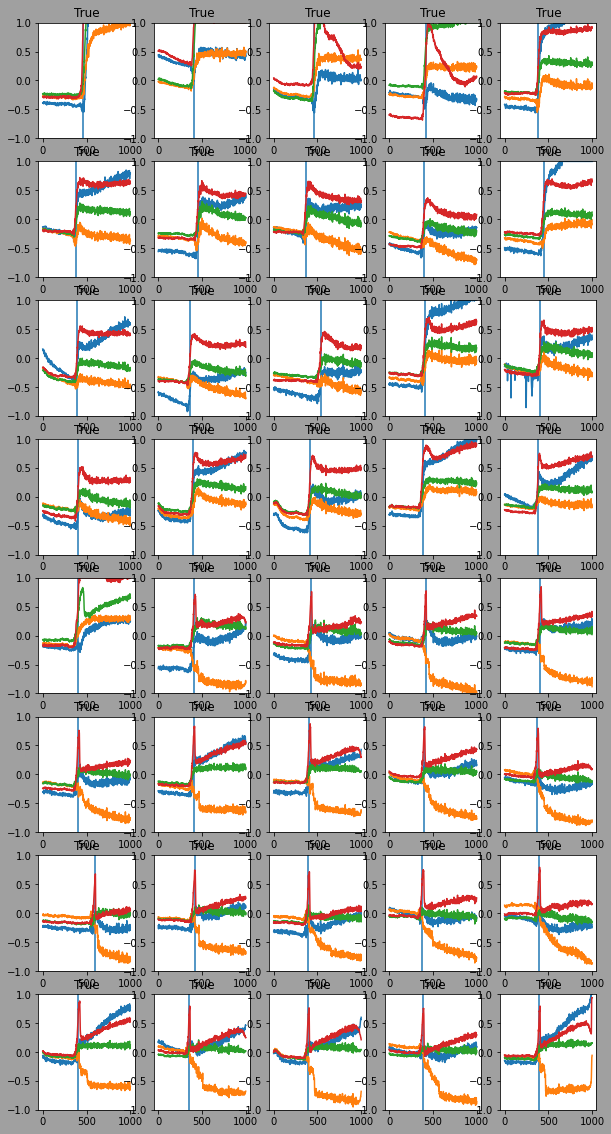

In [33]:
showMeWorking(data=records['Eyebrow'])

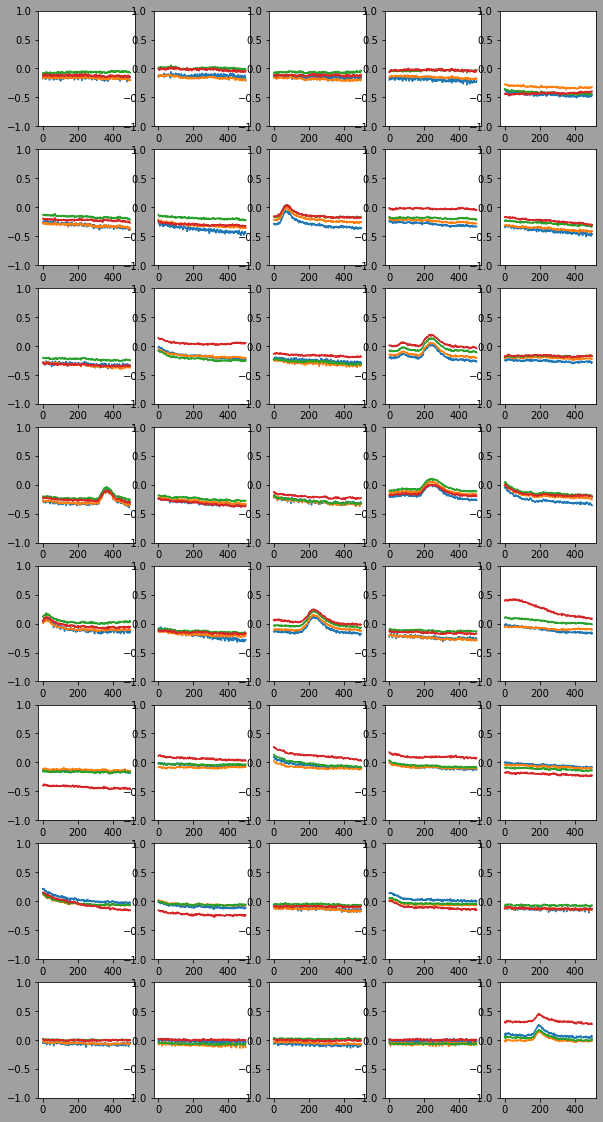

In [42]:
showMeCutted(data=records['Rest'])

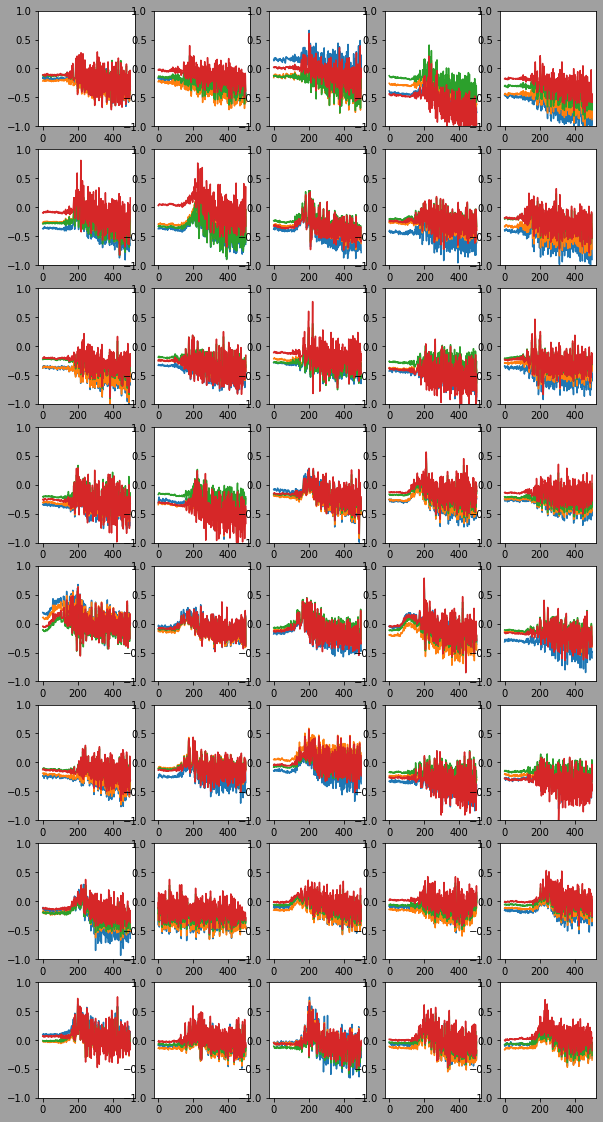

In [43]:
showMeCutted(data=records['Chew'])

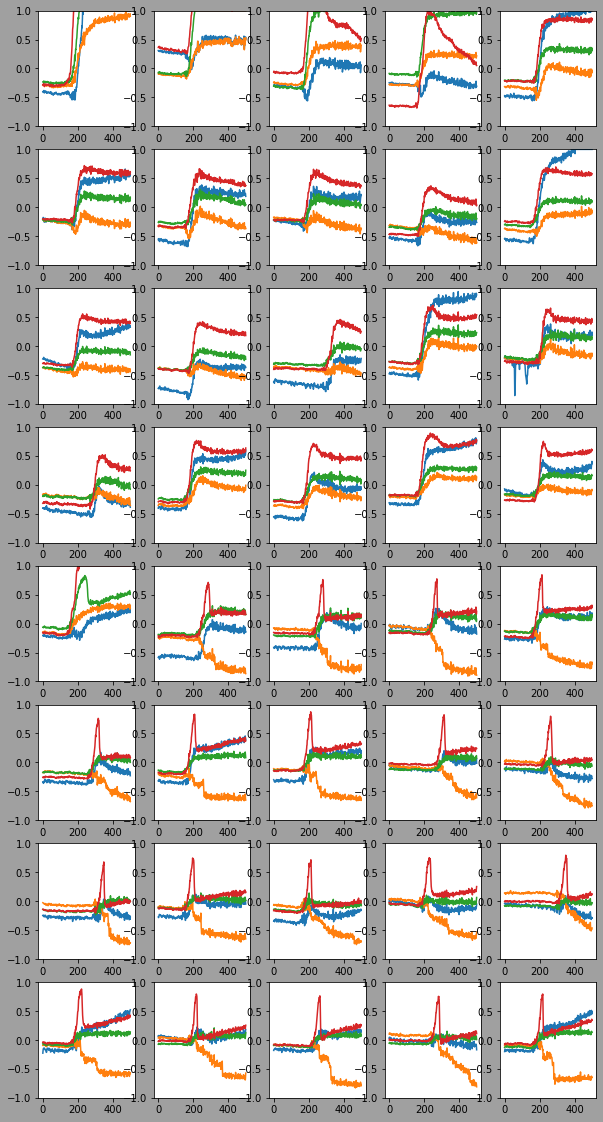

In [44]:
showMeCutted(data=records['Eyebrow'])